# <center> House Prices - Advanced Regression ♾ with Julia 😎 </center>

In [1]:
using Pkg

Les données et leur description sont accéssibles ici: <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data"> house-prices-advanced-regression-techniques </a>


In [2]:
using CSV
using Flux
using Conda
using Impute
using StatsBase
using DataFrames
using StatsPlots
using ScikitLearn
using MLDataUtils
using DecisionTree
using Lathe.preprocess: TrainTestSplit

* ##### Importation des données

In [3]:
df_train = CSV.read("data/train.csv", DataFrame);
df_test = CSV.read("data/test.csv", DataFrame);

* ##### Cinq premières lignes du jeu de données 

In [4]:
head(df_train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour
,Int64,Int64,String,String,Int64,String,String,String,String
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl


* ##### Cinq dernières lignes du jeu de données 

In [5]:
tail(df_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour
,Int64,Int64,String,String,Int64,String,String,String,String
1,2914,160,RM,21,1526,Pave,NA,Reg,Lvl
2,2915,160,RM,21,1936,Pave,NA,Reg,Lvl
3,2916,160,RM,21,1894,Pave,NA,Reg,Lvl
4,2917,20,RL,160,20000,Pave,NA,Reg,Lvl
5,2918,85,RL,62,10441,Pave,NA,Reg,Lvl
6,2919,60,RL,74,9627,Pave,NA,Reg,Lvl


* ##### Suppression de la variable ID

La suppression d'une variable se fait en *réselectionnant* les variables du jeu de données exceptée la variable à supprimer. Avec *Julia*, `!` devant une fonction à valeur de `inplace=True` en python. Il écrase la valeur de la variable et lui assigne le résultat de l'opération de la fonction utilisée.

In [6]:
select!(df_train, Not(:Id));
select!(df_test, Not(:Id));

In [7]:
# Vérifier le type de données retournées. 
@show typeof(df_train)

# @show typeof(df_test)

typeof(df_train) = DataFrame


DataFrame

In [8]:
# Colonnes des données d'apprentissage 
names(df_train)

80-element Vector{String}:
 "MSSubClass"
 "MSZoning"
 "LotFrontage"
 "LotArea"
 "Street"
 "Alley"
 "LotShape"
 "LandContour"
 "Utilities"
 "LotConfig"
 "LandSlope"
 "Neighborhood"
 "Condition1"
 ⋮
 "3SsnPorch"
 "ScreenPorch"
 "PoolArea"
 "PoolQC"
 "Fence"
 "MiscFeature"
 "MiscVal"
 "MoSold"
 "YrSold"
 "SaleType"
 "SaleCondition"
 "SalePrice"

In [9]:
# Colonnes des données de test
names(df_test);

* ##### Division des données en groupe (les zones d'habitation)

In [10]:
gdf = groupby(df_train, :MSZoning);

In [11]:
combine(gdf, nrow, :SalePrice => mode)

,MSZoning,nrow,SalePrice_mode
,String,Int64,Int64
1,RL,1151,135000
2,RM,218,115000
3,C (all),10,40000
4,FV,65,176000
5,RH,16,145000


In [12]:
combine(gdf, nrow,:SalePrice => maximum)

,MSZoning,nrow,SalePrice_maximum
,String,Int64,Int64
1,RL,1151,755000
2,RM,218,475000
3,C (all),10,133900
4,FV,65,370878
5,RH,16,200000


Nous arrivons à utiliser la moyenne `mean` et le mode `mode` de la sorte grâce au package `StatsBase` que nous avons importé.

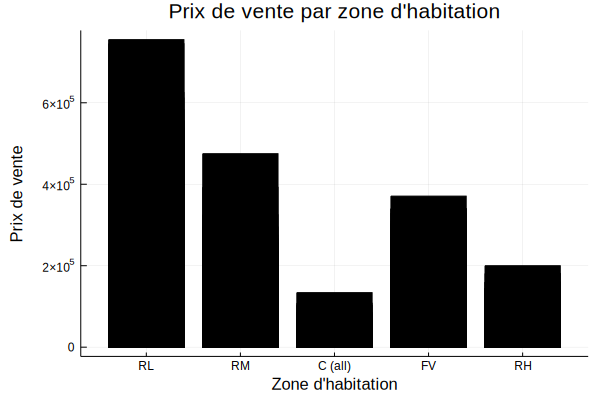

In [13]:
plot(df_train.MSZoning, 
    df_train.SalePrice,
    label="",
    seriestype = :bar, 
    title = "Prix de vente par zone d'habitation", 
    ylabel="Prix de vente",
    xlabel="Zone d'habitation",
    color=:black)

Les maisons se trouvant dans les zones d'habitation à faible densité de population sont les plus demandées. 

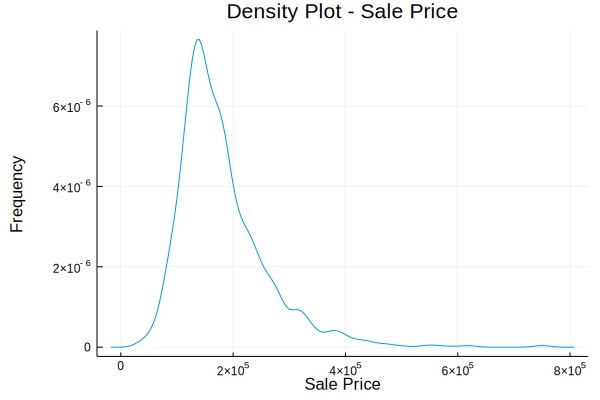

In [14]:
density(
    df_train.SalePrice , 
    title = "Density Plot - Sale Price", 
    ylabel = "Frequency", xlabel = "Sale Price", legend = false)

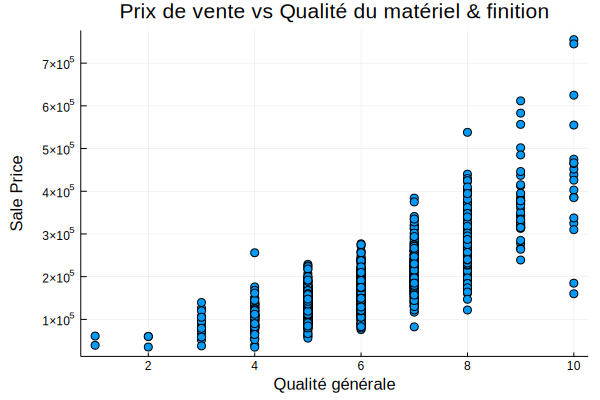

In [15]:
scatter(
    df_train.OverallQual,
    df_train.SalePrice, 
    title = "Prix de vente vs Qualité du matériel & finition", 
    ylabel = "Sale Price", xlabel = "Qualité générale",legend = false)

Plus les matériaux et la finition de la maison sont de bonne qualité, plus chère est la maison. Nous pouvons voir que les maisons avec les meilleures finitions ont les prix les plus élevés.

In [16]:
head(describe(df_train), 5)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,MSSubClass,56.8973,20,50.0,190,,,Int64
2,MSZoning,,C (all),,RM,5,,String
3,LotFrontage,,100,,NA,111,,String
4,LotArea,10516.8,1300,9478.5,215245,,,Int64
5,Street,,Grvl,,Pave,2,,String


Bien qu'il existe des valeurs manquantes dans le jeu de données, la colonne *nmissing* (nombre de valeurs manquantes par colonnes) n'affiche rien.

 > *Julia* considère que les valeurs manquantes sont représentées par l'objet manquant `missing` plutôt que par `NA`; Avec la fonction `allowmissing`, on autorise prise en charge des valeurs manquantes. Après, on remplace tous les `NA` par des objets `missing`.

In [17]:
allowmissing!(df_train);
df_train .= ifelse.(df_train .== "NA" , missing, df_train);

In [18]:
description = describe(df_train)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,Union
1,MSSubClass,56.8973,20,50.0,190,,0,"Union{Missing, Int64}"
2,MSZoning,,C (all),,RM,5,0,"Union{Missing, String}"
3,LotFrontage,,100,,99,110,259,"Union{Missing, String}"
4,LotArea,10516.8,1300,9478.5,215245,,0,"Union{Missing, Int64}"
5,Street,,Grvl,,Pave,2,0,"Union{Missing, String}"
6,Alley,,Grvl,,Pave,2,1369,"Union{Missing, String}"
7,LotShape,,IR1,,Reg,4,0,"Union{Missing, String}"
8,LandContour,,Bnk,,Lvl,4,0,"Union{Missing, String}"
9,Utilities,,AllPub,,NoSeWa,2,0,"Union{Missing, String}"


Avec le résultat de la fonction `describe`, on s'aperçoit que les colonnes ont deux types. Ce qui nous donne par la première variable par exemple `Union{Missing, Int64}` puisqu'elle possède des entiers et des valeurs manquantes.

In [19]:
sort(description[description.nmissing .!= nothing,:], :nmissing, rev=true)[1:7,:]

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,Union
1,PoolQC,,Ex,,Gd,3,1453,"Union{Missing, String}"
2,MiscFeature,,Gar2,,TenC,4,1406,"Union{Missing, String}"
3,Alley,,Grvl,,Pave,2,1369,"Union{Missing, String}"
4,Fence,,GdPrv,,MnWw,4,1179,"Union{Missing, String}"
5,FireplaceQu,,Ex,,TA,5,690,"Union{Missing, String}"
6,LotFrontage,,100,,99,110,259,"Union{Missing, String}"
7,GarageType,,2Types,,Detchd,6,81,"Union{Missing, String}"


Le code ci dessus nous permet de ranger  les variables selon le nombre de valeurs manquantes qu'elles ont. On peut normalment supprimer les 5 premières variables du classement vu le nombre de valeurs manquantes qu'elles possèdent.

In [20]:
select!(df_train, Not([:PoolQC , :MiscFeature, :Alley, :Fence, :FireplaceQu]));
select!(df_test, Not([:PoolQC , :MiscFeature, :Alley, :Fence, :FireplaceQu]));

Pour les variables restantes, nous imputerons les valeurs manquantes. Pour ce faire,
nous choisirons méthode `locf` (remplace la donnée manquante par la dernière observation) du pakage `Impute` [plus de détails ici](https://invenia.github.io/Impute.jl/latest/api/imputation/).

In [21]:
Impute.locf!(df_train);

In [22]:
head(describe(df_train), 5)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,Union
1,MSSubClass,56.8973,20,50.0,190,,0,"Union{Missing, Int64}"
2,MSZoning,,C (all),,RM,5,0,"Union{Missing, String}"
3,LotFrontage,,100,,99,110,0,"Union{Missing, String}"
4,LotArea,10516.8,1300,9478.5,215245,,0,"Union{Missing, Int64}"
5,Street,,Grvl,,Pave,2,0,"Union{Missing, String}"


Après avoir remplacé l'ensemble des valeurs manquantes, nous devons retirer le type `missing` des types autorisés pour les colonnes. Cela ce fait avec la fonction `something`. Il n'existe pas beaucoup de modèles qui permettent le type `missing` dans les types de données autorisées.

In [23]:
df_train  = something.(df_train);

In [24]:
variables_quantitatives = Vector{String}()

String[]

In [25]:
for name in names(df_train)
    if typeof(df_train[name]).parameters[1] != String
        push!(variables_quantitatives, name);
    end
end

Pour le partitionnement des données, on peut utiliser la fonction `TrainTestSplit` du package `Lathe` ou de `ScikitLearn` dont l'utilisation est semblable à celui de python.
<br>

Nous utilisérons seulement les variables quantitatives pour notre regression. Je sais 🥱, c'est pas trop top mais dans une prochaine section nous verrons comment encoder les variables qualitatives😁.

* ##### Partitionnement des données 

In [26]:
traindf, testdf = TrainTestSplit(df_train[variables_quantitatives],.80);

In [27]:
y = convert(Array, traindf[!,:SalePrice]);
X = convert(Array, select(traindf, Not(:SalePrice)));

In [28]:
Xsh,ysh = shuffleobs((permutedims(X), y));

In [29]:
# Split data 
(X_train, y_train), (X_test, y_test) = splitobs((Xsh, ysh); at=0.80);

In [30]:
X_train = Array(permutedims(X_train));
y_train = Array(y_train);
X_test = Array(permutedims(X_test));
y_test = Array(y_test);

Notre modèle de machine learning se fera avec `ScikitLearn`, et oui 😉; On pourrait aussi le faire avec `GLM` qui rapppelle R évidemment. 
<br>
C'est ça... *Julia* 🥰, tout le monde se sens à la maison 🦾

In [31]:
using ScikitLearn: fit!, predict
using ScikitLearn.Models: LinearRegression

In [32]:
lreg = LinearRegression(multi_output=false)

LinearRegression{Matrix{Float64}, Float64}(#undef, #undef)

In [33]:
fit!(lreg, X_train, y_train)

LinearRegression{Matrix{Float64}, Float64}([-132.9756682737147; 0.537355108058441; … ; -26.82747165210753; -1474.1046916578152;;], [1.7721748083622644e6])

* ##### Prédiction à l'aide du modèle obtenu

In [34]:
y_pred = predict(lreg, X_test);

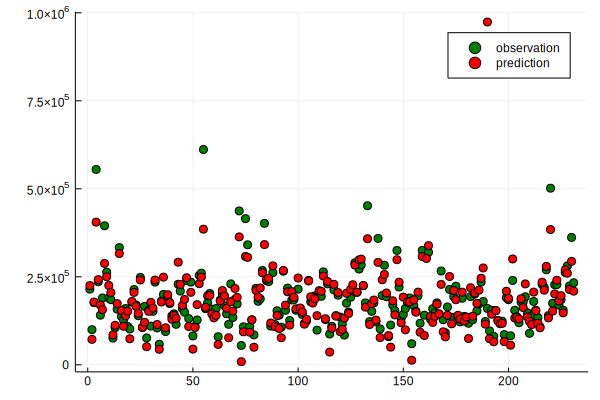

In [35]:
x = 1:231
y2 = [y_test, y_pred]
plot(x, y2, seriestype = :scatter,
    color = [:green :red],
    label=["observation" "prediction"])

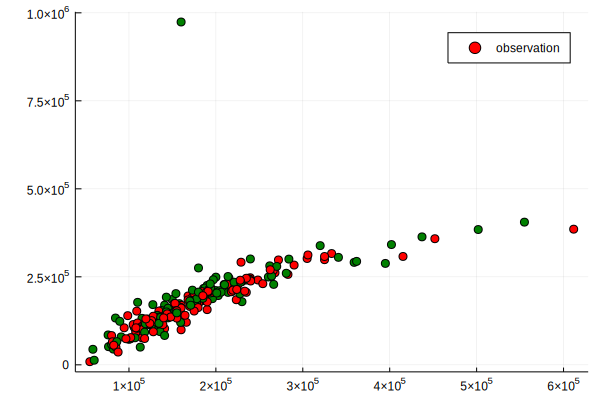

In [36]:
plot(y_test, y_pred, seriestype = :scatter, 
    color=[:red, :green], 
    label=["observation" "prediction"])

Comme vous pouvez le voir, *Julia* est un langage assez puissant qui pour moi serait sinon est une réelle alternative à Python pour le machine learning.